# Gradient Boosted Regression Model
---

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# read in files as dfs
mpls_df = pd.read_csv('resources/mpls_solar_weather.csv')
olg_df = pd.read_csv('resources/olg_solar_weather.csv')

In [84]:
# only include rows with power_delivered > 0
mpls_df = mpls_df[mpls_df.power_delivered > 0]

# columns on which to run ML model
features = [
    'clouds_all', 'temp_f', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
    'rain_1h', 'snow_1h', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day'
]
target = 'power_delivered'

## XGBoost Regression

In [85]:
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import KFold, cross_val_score

In [86]:
# define target and features
X = mpls_df[features].copy()
y = mpls_df[target]

# X = olg_df[features].copy()
# y = olg_df[target]

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [87]:
# scale data
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# for k-fold cross validation
X_scaled = X_scaler.transform(X)

C:\Users\Jackmarius\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [88]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 1000)

In [89]:
# xg_reg.fit(X_train,y_train)
xg_reg.fit(X_train_scaled, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [90]:
# make predictions
preds = xg_reg.predict(X_test_scaled)

In [91]:
# compute root of mean squared error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

r2 = r2_score(y_test, preds)
print("r2 score: %f" % (r2))

RMSE: 490.097280
r2 score: 0.865838


In [107]:
# set up 10-fold cross-validation
kfold = KFold(n_splits=10, random_state=42)

# get cross-val score
results = cross_val_score(xg_reg, X_scaled, y, cv=kfold)

print("Cross-Validation Score: %.4f (%.4f)" % (results.mean(), results.std()))

Cross-Validation Score: 0.7929 (0.0857)


In [108]:
results

array([0.80454025, 0.86237587, 0.62297168, 0.68807572, 0.84448199,
       0.87875232, 0.79896436, 0.70159799, 0.85489421, 0.87280632])

In [94]:
features_df = pd.DataFrame(features, xg_reg.feature_importances_).reset_index()

features_df.columns = ['feature', 'importance']

features_df = features_df.sort_values('feature', ascending=True).reset_index()

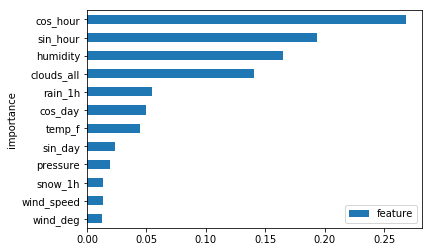

In [95]:
features_df.plot('importance', 'feature', kind='barh')

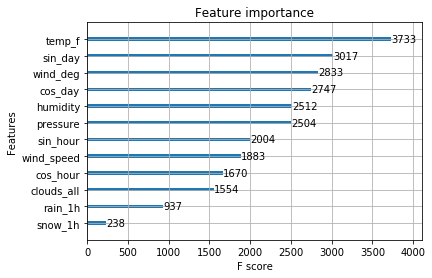

In [102]:
xg_reg.get_booster().feature_names = features
xgb.plot_importance(xg_reg)

In [96]:
# xgb.plot_tree(xg_reg, num_trees=0)
# plt.show()
# xgb.to_graphviz(xg_reg, num_trees=4)

In [104]:
xg_reg.get_booster().feature_names

['clouds_all',
 'temp_f',
 'pressure',
 'humidity',
 'wind_speed',
 'wind_deg',
 'rain_1h',
 'snow_1h',
 'sin_hour',
 'cos_hour',
 'sin_day',
 'cos_day']

In [106]:
mpls_df[features].columns

Index(['clouds_all', 'temp_f', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'snow_1h', 'sin_hour', 'cos_hour', 'sin_day',
       'cos_day'],
      dtype='object')

In [51]:
# convert predictions to df to plot
predictions = pd.DataFrame(preds, y_test).reset_index(drop=False)
predictions.columns = ['delivered', 'predicted']
predictions.head(10)

,delivered,predicted
0,3817,3602.457275
1,641,639.267700
2,933,976.368591
3,2291,2120.322510
4,96,300.268433
5,149,285.354706
6,3958,3950.129395
7,4028,3512.105957
8,826,785.846313
9,13,-31.788574


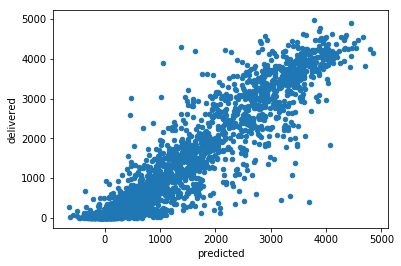

In [52]:
predictions.plot('predicted', 'delivered', kind='scatter')